In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving TG_STAID002759.txt to TG_STAID002759.txt


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.4 MB/s 
     |████████████████████████████████| 9.8 MB 65.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import statsmodels
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
import pmdarima as pm
import plotly.express as pe

In [ ]:
#Loading the .txt file using read_csv command, and skipping thfirst 18 rows, as they are text data, and parsing the date column
data=pd.read_csv('TG_STAID002759.txt', sep=',', skiprows=18, parse_dates=True, index_col='    DATE')

In [ ]:
#Copying the dataset, to keep the original untouched
df=data.copy()

In [ ]:
#Checking the first five rows
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [ ]:
#Checking number of rows and columns
df.shape

(53416, 3)

In [ ]:
#Checking the features
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [ ]:
#Checking for null values
df.isnull().sum()

 SOUID    0
   TG     0
 Q_TG     0
dtype: int64

In [ ]:
#Checking the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0    SOUID  53416 non-null  int64
 1      TG   53416 non-null  int64
 2    Q_TG   53416 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [ ]:
df.describe()

,SOUID,TG,Q_TG
count,53416.000000,53416.000000,53416.000000
mean,119348.917029,56.861221,0.033043
std,8023.696030,615.301051,0.544194
min,111448.000000,-9999.000000,0.000000
25%,111448.000000,33.000000,0.000000
50%,111448.000000,93.000000,0.000000
75%,127488.000000,157.000000,0.000000
max,128124.000000,305.000000,9.000000


- From the above analysis, we see in temperature column, there are extremely high value is present, -9999, which is unrealistic
- Other than that, the rest of the data looks like ok
- we have to handle the outliers later

In [ ]:
#Droping columns SOUID and Q_TG
df=df.drop(columns=[' SOUID', ' Q_TG'], axis=1)

In [ ]:
#Renaming the column to Temperature
df=df.rename(columns = {'   TG':'Temperature'})

In [ ]:
#Multiplying temperature values with 0.1
df['Temperature']=df['Temperature']*0.1

In [ ]:
#Extracting year and month column from the date
df['Year']=df.index.year
df['Month']=df.index.month
df.head()

,Temperature,Year,Month
DATE,,,
1876-01-01,2.2,1876,1
1876-01-02,2.5,1876,1
1876-01-03,0.3,1876,1
1876-01-04,-5.8,1876,1
1876-01-05,-9.8,1876,1


In [ ]:
#Adding a new column timestep
df['Timestep']=list(range(len(df)))

In [ ]:
# Checking the outlier values in temperature feature
df.loc[(df['Temperature'] < -50), ['Temperature']]

,Temperature
DATE,
1945-04-25,-999.9
1945-04-26,-999.9
1945-04-27,-999.9
1945-04-28,-999.9
1945-04-29,-999.9
...,...
1945-11-02,-999.9
1945-11-03,-999.9
1945-11-04,-999.9


In [ ]:
#Replacing the outlier values with np.nan
df['Temperature']=np.where(df['Temperature'] < -50, np.nan, df['Temperature'])

In [ ]:
#Checking the whether the replacement had worked
df.describe()

,Temperature,Year,Month,Timestep
count,53220.000000,53416.000000,53416.000000,53416.000000
mean,9.389521,1948.624401,6.515351,26707.500000
std,7.875618,42.218477,3.450975,15420.015326
min,-22.600000,1876.000000,1.000000,0.000000
25%,3.400000,1912.000000,4.000000,13353.750000
50%,9.400000,1949.000000,7.000000,26707.500000
75%,15.700000,1985.000000,10.000000,40061.250000
max,30.500000,2022.000000,12.000000,53415.000000


- From above we can see the outlier values are replaced by np.nan

In [ ]:
#Implementing the bfill method to replace the np.nan values
df['Temperature']=df['Temperature'].fillna(method='bfill')

In [ ]:
#Checking again whether all nan values were replaced
df.isna().sum()

Temperature    1
Year           0
Month          0
Timestep       0
dtype: int64

- We see still there is only one nan value is remaining, and we assume that is the value is the last value in the dataframe, and there bfill method did not work and we have to apply ffill for that value

In [ ]:
#Checking last values to get sure about our assumption
df.tail()

,Temperature,Year,Month,Timestep
DATE,,,,
2022-03-27,9.7,2022,3,53411
2022-03-28,10.8,2022,3,53412
2022-03-29,8.0,2022,3,53413
2022-03-30,5.3,2022,3,53414
2022-03-31,NaN,2022,3,53415


In [ ]:
#Applying the ffill method to replace the last nan value from the dataframe
df['Temperature']=df['Temperature'].fillna(method='ffill')
df.tail()

,Temperature,Year,Month,Timestep
DATE,,,,
2022-03-27,9.7,2022,3,53411
2022-03-28,10.8,2022,3,53412
2022-03-29,8.0,2022,3,53413
2022-03-30,5.3,2022,3,53414
2022-03-31,5.3,2022,3,53415


In [ ]:
#Plotting  a lineplot for the dataset

pe.line(df.Temperature)


- From the above line plot, we observe that timeseries data follows a specific seasonal pattern

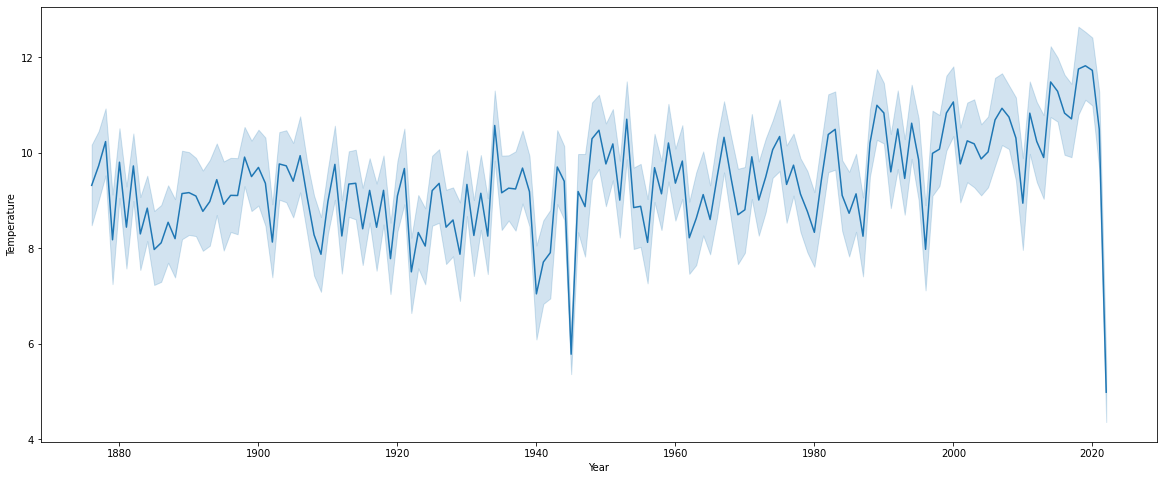

In [ ]:
#Another lineplot by year
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Year', y='Temperature')
plt.show()

- From the above plot we observe, there is general trend of temperature, which is increasing each year with a small increase in temperature, which also indicate the global warming issue, specially there is a shift post second wolrd war period, because of boom in consumption and living standard in advanced world
- Second is there is a seasonal trend, a regular up and down in temperature accoring to the chage in season, which is a normal phenomenon in weather data

In [ ]:
#Defining X and y variable, and reshaping the X as there are only one feature or x variable , and instiating the LinearRegression model
X=df['Timestep'].values.reshape(-1, 1)
y=df['Temperature']
ln=LinearRegression()

In [ ]:
# Fitting the model to X and y
ln.fit(X,y)

LinearRegression()

In [ ]:
# Predicting the temperature and creating a feature Trend 
df['Trend']=ln.predict(X)
df.head()

,Temperature,Year,Month,Timestep,Trend
DATE,,,,,
1876-01-01,2.2,1876,1,0,8.511750
1876-01-02,2.5,1876,1,1,8.511782
1876-01-03,0.3,1876,1,2,8.511815
1876-01-04,-5.8,1876,1,3,8.511848
1876-01-05,-9.8,1876,1,4,8.511880


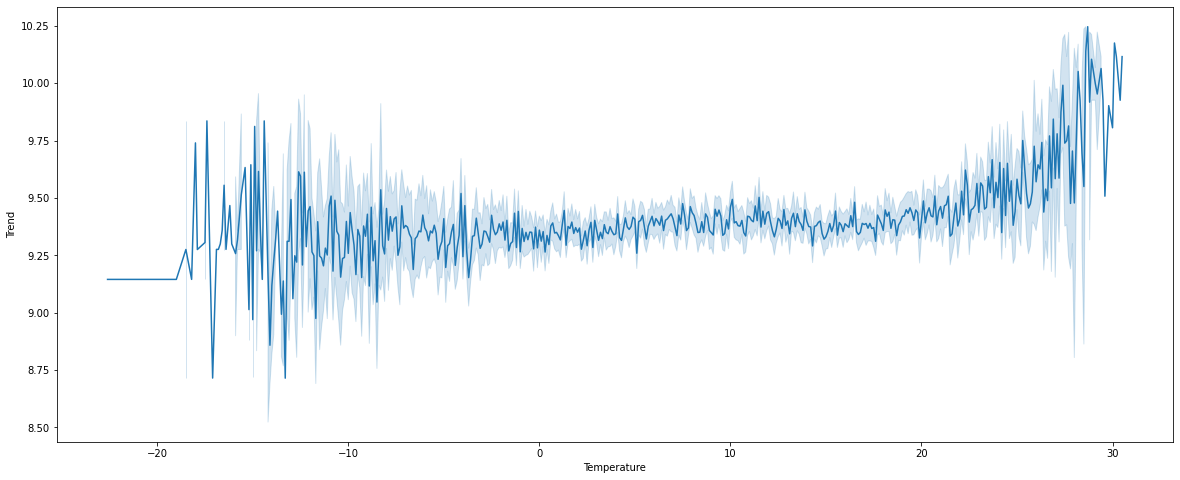

In [ ]:
#Drawing  a lineplot on temperature and trend data
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Temperature', y='Trend')
plt.show()

In [ ]:
#Creating a variable seasonal dummies and droping the first column
seasonal_dummies=pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)

In [ ]:
#Joining the seasonal dummies in the dataframe
df=df.join(seasonal_dummies)
df.head()

,Temperature,Year,Month,Timestep,Trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
1876-01-01,2.2,1876,1,0,8.511750,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1876,1,1,8.511782,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,1876,1,2,8.511815,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,1876,1,3,8.511848,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,1876,1,4,8.511880,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Droping year, month and trend columns, defining X and y varaible
X=df.drop(columns=['Temperature', 'Year', 'Month', 'Trend'])
y=df['Temperature']

In [ ]:
# Instiating the Linear Regression model
ln1=LinearRegression()

In [ ]:
#Fitting the model
ln1.fit(X, y)

LinearRegression()

In [ ]:
#Predicting the trend and saving under the feature Seasonal_trend
df['Seasonal_Trend']=ln1.predict(X)
df.head()

,Temperature,Year,Month,Timestep,Trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Seasonal_Trend
DATE,,,,,,,,,,,,,,,,,
1876-01-01,2.2,1876,1,0,8.511750,0,0,0,0,0,0,0,0,0,0,0,-0.872503
1876-01-02,2.5,1876,1,1,8.511782,0,0,0,0,0,0,0,0,0,0,0,-0.872470
1876-01-03,0.3,1876,1,2,8.511815,0,0,0,0,0,0,0,0,0,0,0,-0.872437
1876-01-04,-5.8,1876,1,3,8.511848,0,0,0,0,0,0,0,0,0,0,0,-0.872403
1876-01-05,-9.8,1876,1,4,8.511880,0,0,0,0,0,0,0,0,0,0,0,-0.872370


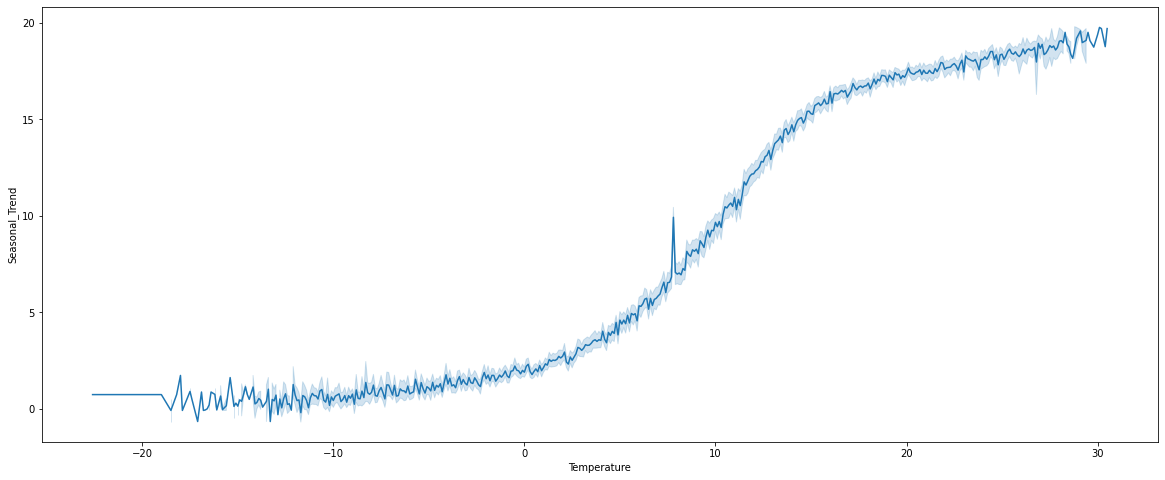

In [ ]:
#Plotting a lineplot with temperature and seasonal_trend
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Temperature', y='Seasonal_Trend')
plt.show()


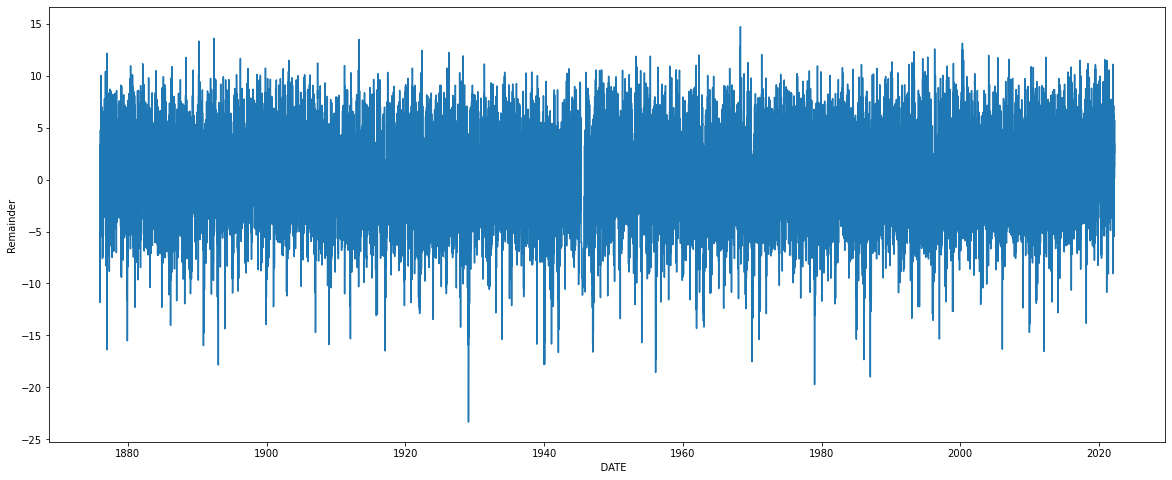

In [ ]:
#Extracting the remainder from temperature the seasonal_
plt.figure(figsize=(20,8))
df['Remainder']=df['Temperature']-df['Seasonal_Trend']
sns.lineplot(data=df['Remainder'])
plt.show()

In [ ]:
#Saving the to_csv with remainder feature
df['Remainder'].to_csv('remainder.csv')

In [ ]:
#Reading the remainder dataset
df1=pd.read_csv('remainder.csv', parse_dates=True, index_col=0)
df1.head()

,Remainder
DATE,
1876-01-01,3.072503
1876-01-02,3.372470
1876-01-03,1.172437
1876-01-04,-4.927597
1876-01-05,-8.927630


In [ ]:
# Plot the data
def plot_remainder(df, title='Temperature value after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Remainder')
    plt.show()

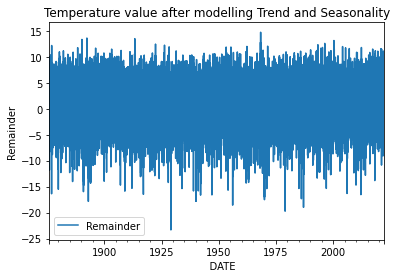

In [ ]:
plot_remainder(df1)

In [ ]:
#Checking the number of rows and columns
df1.shape

(53416, 2)

In [ ]:
#Checking the datatype
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53416 entries, 0 to 53415
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0       DATE   53416 non-null  object 
 1   Remainder  53416 non-null  float64
dtypes: float64(1), object(1)
memory usage: 834.8+ KB


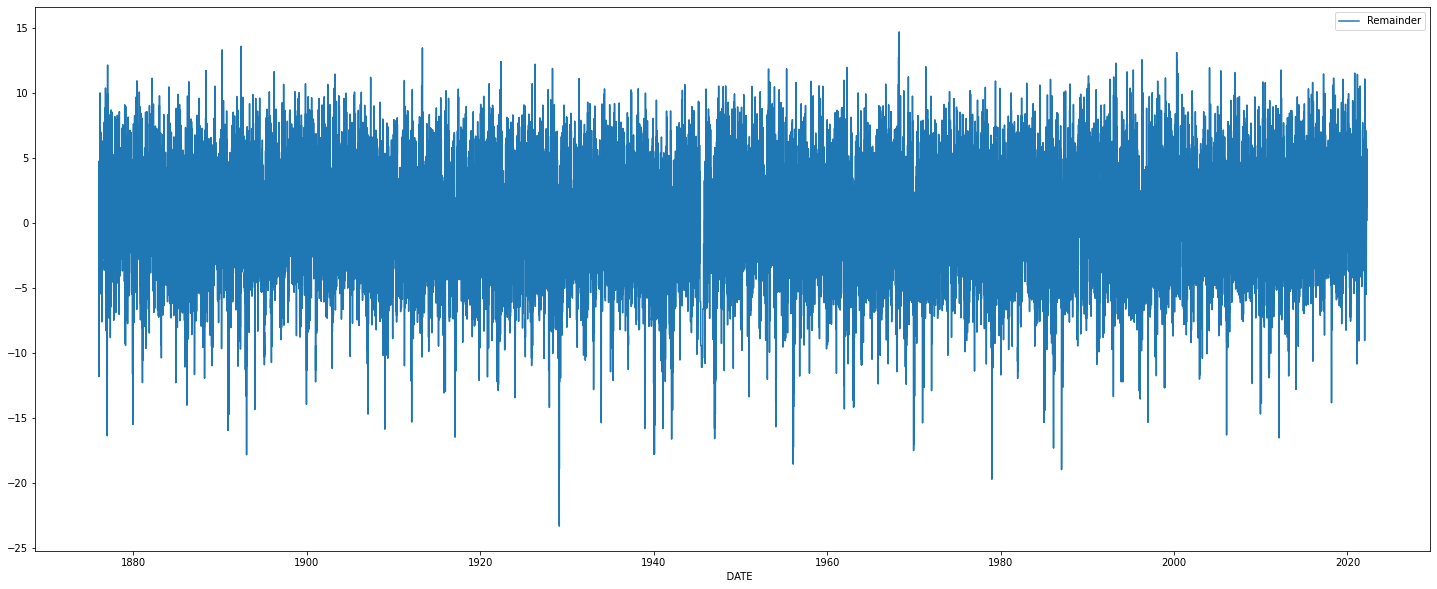

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(data=df1)
plt.show()

In [ ]:
#Concept of Stationarity
#The main charecteristics of the data is not time dependant
# e.g. mean, variance will not change overtime
# White noise: random, stationary
# np.random

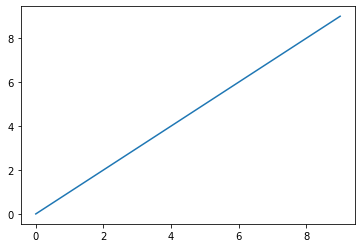

In [ ]:
data1 =range(10)
plt.plot(data1)


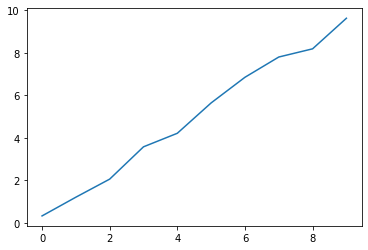

In [ ]:
# add a random number between 0 and 1 [0, 1), means 1 is excluded, and 0 is included, the number can be anyththing betwen 0 and 1, but not 1
# Problem, we only add a number
plt.plot(data1 + np.random.random(10))

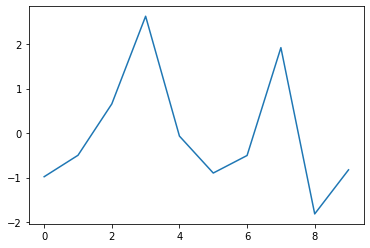

In [ ]:
plt.plot(np.random.normal(0, 1, 10))

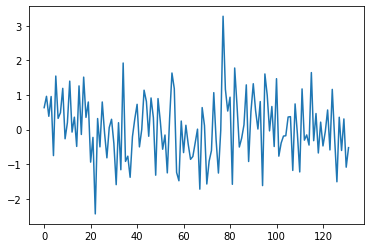

In [ ]:
plt.plot(np.random.normal(0, 1, 132))

In [ ]:
#WHywe add white noise
#Stationarity
#it has auto correlation
#Autocorrelation

In [ ]:
$MSE = \frac{1}{n} \sum i^n (\hat{y} - y_i)^2$
$Var =\frac{1}{n} \sum i^n (\bar{y} - y_i)^2$ = \frac{1}{n} \sum i^n (\bar{y} - y_i) \ cdot  #Population variance
$Covariance(y,x)=\frac{1}{n} \sum i_n (\bar{y} - y_i) \cdot (\bar{x}- x_i)$
$Correlation(y,x) =  \frac{Cov(y,x)}{\sigma(y)\cdot\sigma(x)}$

In [ ]:
Autocorreltion

In [ ]:
# Creating lag1
df1['lag']=df1['Remainder'].shift(1)
df1.head()

,Remainder,lag
DATE,,
1876-01-01,3.072503,NaN
1876-01-02,3.372470,3.072503
1876-01-03,1.172437,3.372470
1876-01-04,-4.927597,1.172437
1876-01-05,-8.927630,-4.927597


In [ ]:
df1['lag1']=df1['Remainder'].shift(2)
df1.head()

,Remainder,lag,lag1
DATE,,,
1876-01-01,3.072503,NaN,NaN
1876-01-02,3.372470,3.072503,NaN
1876-01-03,1.172437,3.372470,3.072503
1876-01-04,-4.927597,1.172437,3.372470
1876-01-05,-8.927630,-4.927597,1.172437


In [ ]:
#Checking the correlation bewteen remainder and lag
df1.corr()

,Remainder,lag,lag1
Remainder,1.000000,0.807008,0.605387
lag,0.807008,1.000000,0.807008
lag1,0.605387,0.807008,1.000000


In [ ]:
#np.corrcoef(np.random.normal(0,1, 132))

In [ ]:
# AR(1) is a  linear regression with the lag1 as X and the remainder as y
AR has the parameter p -order (number of lags)

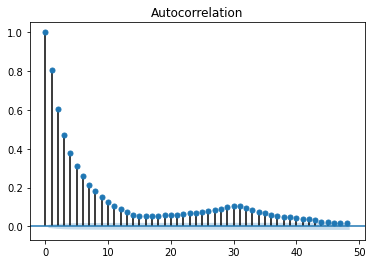

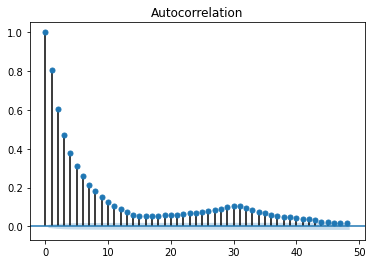

In [ ]:
#Ploting acf
plot_acf(df1['Remainder'])

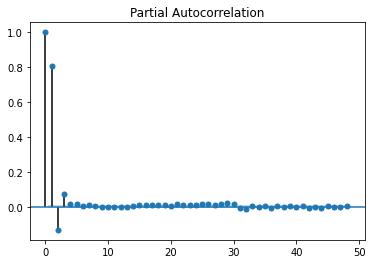

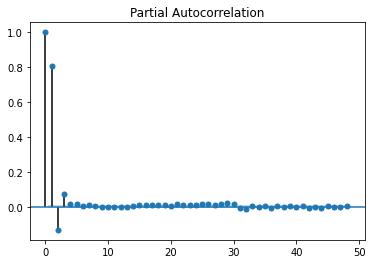

In [ ]:
#Plotting partial correlation
plot_pacf(df1['Remainder'])

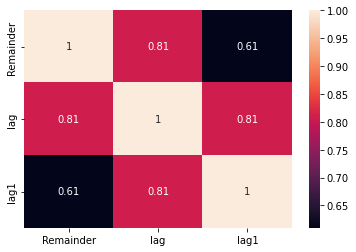

In [ ]:
sns.heatmap(round(df1.corr(), 2), annot=True)

In [ ]:
# Drop missing values
df1.dropna(inplace=True)
df1.head()

,Remainder,lag,lag1
DATE,,,
1876-01-03,1.172437,3.372470,3.072503
1876-01-04,-4.927597,1.172437,3.372470
1876-01-05,-8.927630,-4.927597,1.172437
1876-01-06,-6.827664,-8.927630,-4.927597
1876-01-07,-5.727697,-6.827664,-8.927630


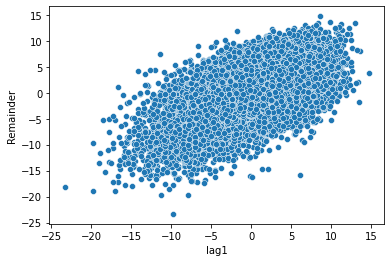

In [ ]:
sns.scatterplot(x='lag1', y='Remainder', data=df1)

In [ ]:
# Assign X and y
X = df1[['lag1']]
y = df1['Remainder']

In [ ]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [ ]:
# Create predictions
df1['predictions_ar1'] = m.predict(X)
df1.head()

,Remainder,lag,lag1,predictions_ar1
DATE,,,,
1876-01-03,1.172437,3.372470,3.072503,1.859914
1876-01-04,-4.927597,1.172437,3.372470,2.041507
1876-01-05,-8.927630,-4.927597,1.172437,0.709653
1876-01-06,-6.827664,-8.927630,-4.927597,-2.983180
1876-01-07,-5.727697,-6.827664,-8.927630,-5.404716


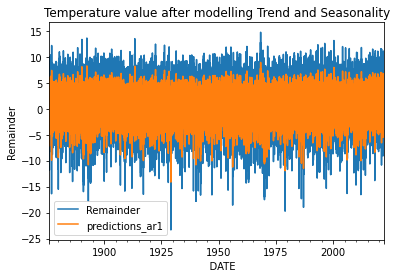

In [ ]:
# Plot the original remainder and the prediction
plot_remainder(df1[['Remainder', 'predictions_ar1']])

**Applying SARIMA**

In [ ]:
#Saving the to_csv with remainder feature
df.to_csv('clean.csv')

In [ ]:
df2=pd.read_csv('clean.csv', parse_dates=True, index_col=0)

In [ ]:
df2.head()

,Temperature,Year,Month,Timestep
DATE,,,,
1876-01-01,2.2,1876,1,0
1876-01-02,2.5,1876,1,1
1876-01-03,0.3,1876,1,2
1876-01-04,-5.8,1876,1,3
1876-01-05,-9.8,1876,1,4


In [ ]:
df2=df2.drop(columns=['Year', 'Month', 'Timestep'], axis=1)

In [ ]:
df2.shape

(23416, 1)

In [ ]:
df2.head()

,Temperature
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [ ]:
df2=df2.drop(df2.index[0:30000], axis=0)

In [ ]:
df2.head()

,Temperature
DATE,
1958-02-20,1.4
1958-02-21,-0.6
1958-02-22,-1.4
1958-02-23,-2.0
1958-02-24,-2.9


In [ ]:
y=df2['Temperature']

***Basic SARIMA model***

In [ ]:
arima = pm.AutoARIMA(
    m=4,              # seasonality cycle            # apply difference             # apply seasonal difference
    seasonal=True
)

arima.fit(y)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23416
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -52518.182
Date:                Fri, 29 Apr 2022   AIC                         105044.364
Time:                        12:19:34   BIC                         105076.608
Sample:                             0   HQIC                        105054.833
                              - 23416                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6068      0.012     52.244      0.000       0.584       0.630
ma.L1         -0.6249      0.012    -52.308      0.000      -0.648      -0.601
ma.L2         -0.2249      0.007    -31.709      0.000      -0.239      -0.211
sigma2         5.1964      0.042    124.176      0.000       5.114       5.278
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               596.52
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

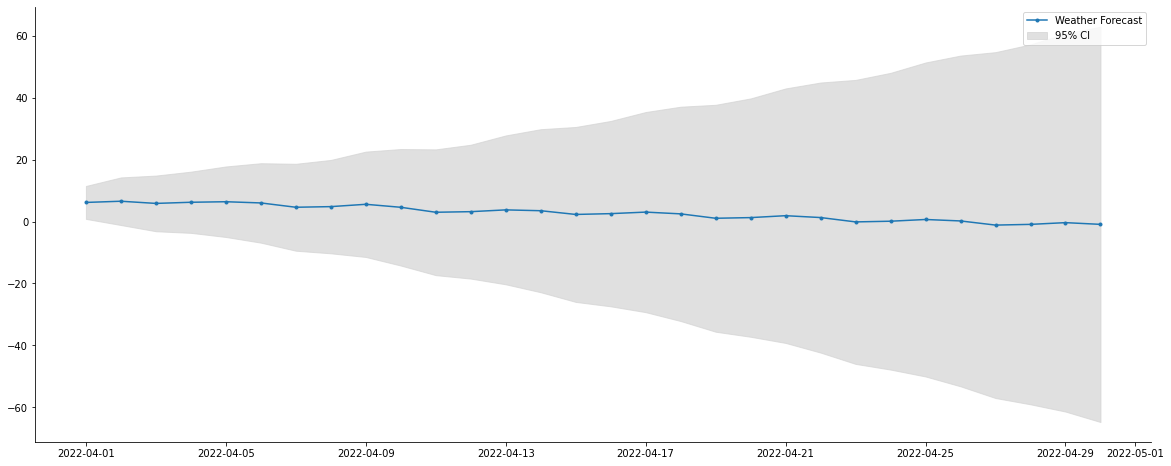

In [ ]:
# forecast for the next 5 years with uncertainty area
y_forecast, ci = arima.predict(n_periods=30, return_conf_int=True)

# create some date values for the forecast horizon
index_vals = pd.date_range('2022-04-01', '2022-04-30')


plt.figure(figsize=(20,8))
plt.fill_between(index_vals.values, ci[:,0], ci[:, 1], alpha=0.7, color='lightgrey', label='95% CI')
plt.plot(index_vals.values, y_forecast, label='Weather Forecast', marker='.')
sns.despine()
plt.legend()

In [ ]:
arima = pm.AutoARIMA(
    m=365,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,             # seasonality cycle
    d=1,               # apply differences
    D=1,               # apply seasonal difference
    seasonal=True,
    test='adf'
)

arima.fit(y)
arima.summary()

array([3.4, 6.6, 8.2, ..., 8. , 5.3, 5.3])

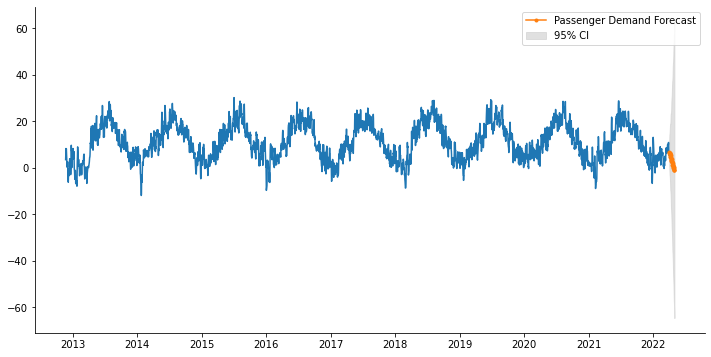

In [ ]:
# forecast for the next 5 years with uncertainty area
y_forecast, ci = arima.predict(n_periods=30, return_conf_int=True)

# create some date values for the forecast horizon
index_vals = pd.date_range('2022-04-01', '2022-04-30')


plt.figure(figsize=(12,6))
plt.plot(y[20000:].index.values, y[20000:].values)
plt.fill_between(index_vals.values, ci[:,0], ci[:, 1], alpha=0.7, color='lightgrey', label='95% CI')
plt.plot(index_vals.values, y_forecast, label='Passenger Demand Forecast', marker='.')
sns.despine()
plt.legend()

In [ ]:
arima = pm.AutoARIMA(
    m=4,
    start_p=3,
    start_q=3,
    max_p=5,
    max_q=5,             # seasonality cycle
    d=1,               # apply differences
    D=1,               # apply seasonal difference
    seasonal=True,
)

arima.fit(y)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                23416
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 4)   Log Likelihood              -56560.678
Date:                           Fri, 29 Apr 2022   AIC                         113133.356
Time:                                   12:53:08   BIC                         113181.722
Sample:                                        0   HQIC                        113149.060
                                         - 23416                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0448      0.006      7.325      0.000       0.033       0.057
ar.L2         -0.1714      0.006    -27.293      0.000      -0.184      -0.159
ar.L3         -0.0875      0.006    -14.088      0.000      -0.100      -0.075
ar.S.L4       -0.7282      0.006   -122.482      0.000      -0.740      -0.716
ar.S.L8       -0.3580      0.006    -61.505      0.000      -0.369      -0.347
sigma2         7.3448      0.059    125.045      0.000       7.230       7.460
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):               540.11
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""